# Deep Learning with Python
# 5.3.1 - ConvNet Visualization - Intermediate Layer Outputs

In this approach, we visualize the activations produced by intermediate layers in a CNN in response to an input image.

This helps us get an overview/high-level idea about what each filter actually looks for in an input image.

A more advanced version of this involves using gradient descent to construct an image that maximises the filter's output.

In [1]:
# Will be using the baseline ConvNet model for this - so must import
from tensorflow.keras.models import load_model

In [3]:
model = load_model('cats_and_dogs_small.h5')

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
# Output the model's summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       147584    
__________

## Get a Test Image

In [9]:
# `image` will preprocess the image into a 4D tensor
from tensorflow.keras.preprocessing import image

In [10]:
import numpy as np

In [14]:
# Specifying the path for the image
img_path = '/Users/saads/OneDrive/Desktop/DL-Python/chapter-5/ch-5-repeat/cats_dogs_small/test/cats/cat.1700.jpg'

# Load the image from the specified path as a PIL object
img = image.load_img(img_path, target_size=(150, 150))

# Transform to a numpy array
img_tensor = image.img_to_array(img)

# Reshaping the image so that it is compatible with the model
img_tensor = np.expand_dims(img_tensor, axis=0)

# Regularizing pixel values
img_tensor /= 255.

In [15]:
# Display the image as a test picture
import matplotlib.pyplot as plt
%matplotlib inline

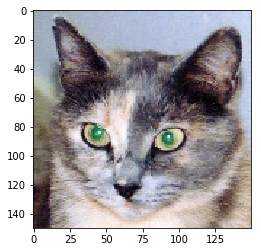

In [16]:
# Only one image in the numpy batch of tensors - this is the test image
plt.imshow(img_tensor[0])
plt.show()

In [17]:
# Instantiating model from input tensor and list of output tensors
from tensorflow.keras import models

# References to first 8 convolutional and max pooling layers in the model
layer_outputs = [layer.output for layer in model.layers[:8]]

# Create a new model with the model's input and output tensors
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

When fed an image input, this model reutrns the values of the layer activations in the original model. This is single input, multi output model. Specifically, this model has one input and eight outputs: one output per layer activation.

In [18]:
# Returns a list of five np arays: one array per layer activation
activations = activation_model.predict(img_tensor)

In [19]:
# Activation of the first convolution layer for the cat image input
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


The first layer produces 32 different feature maps, each of which is of size 148 px by 148 px. We can examine an individual activation map by indexing.

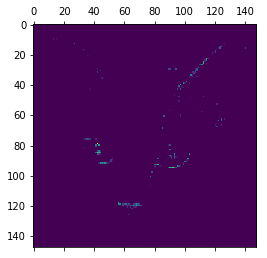

In [23]:
import matplotlib.pyplot as plt
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

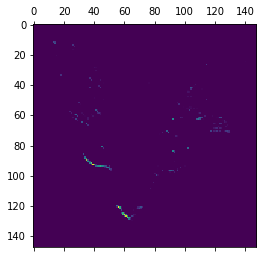

In [26]:
# What agbout the seventh filter?
plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')

## Complete Visualization
- Plotting activation maps for all channels/filters for all filter maps in all layers.
- This will help us visualize trends in CNN feature extraction.

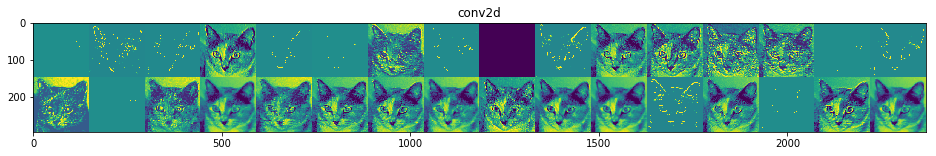

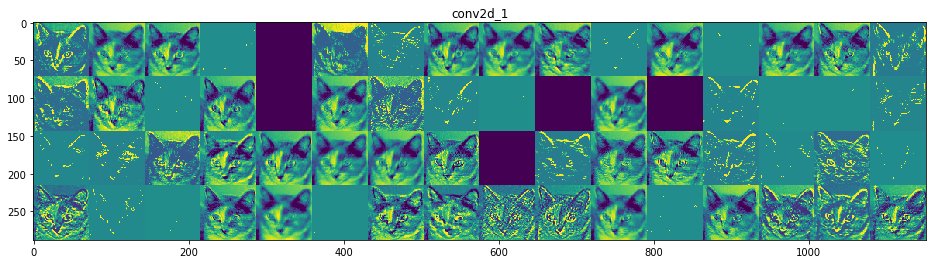

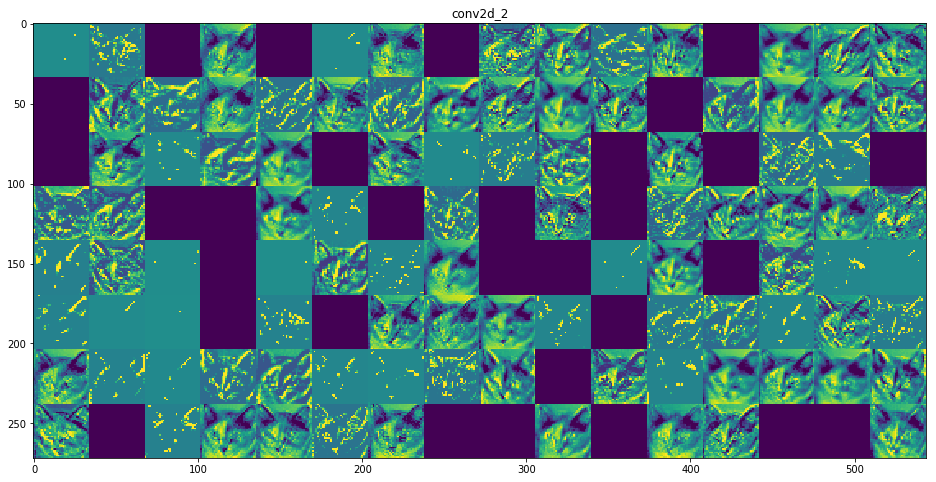

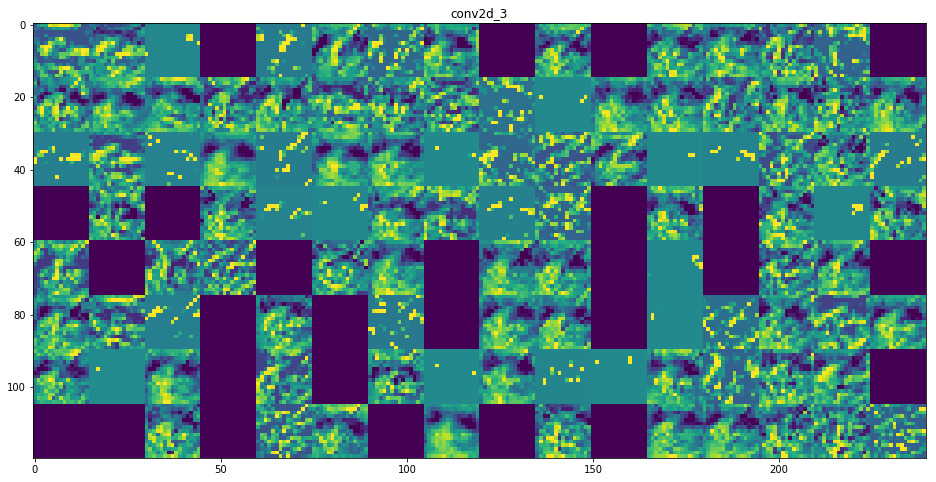

In [46]:
# Names of the layers will be stored in list for annotating plot
layer_names = []

# Parse only the convolutional/pooling layers in the model 
for layer in model.layers[:8]:
    layer_names.append(layer.name)

# Number of filters activations per row of the grid
images_per_row = 16

# Display the feature maps one by one - Zip will combine two different lists
# into one based on a common index
for layer_name, layer_activation in zip(layer_names, activations):
     # feature map has shape(1, size, size, features) - each feature is a filter
    n_features = layer_activation.shape[-1]
    
    # Get the size (width/height) of each image - used for sizing the final output
    size = layer_activation.shape[1]
    
    # Tiles the channels in the activation matrix
    # Number of columns = total number of filters / number of filters to display per row
    n_cols = n_features // images_per_row
    
    # np array to hold pixel values of the activations - `size` is used to define dimensions
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    # Tiles each filter into a big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            
            # Styling the image to make it visually palatable
            channel_image -= channel_image.mean()       # Mean normalization - mean is 0
            channel_image /= channel_image.std()        # Std normaliztaion - now std is 1
            channel_image *= 64                         # Scale all pixels by 64
            channel_image += 128                        # add offset of 128 
            
            # Remove all pixels that fall outside the [0, 255] range
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            
            # Store the modified image's pixel values in the original grid np array
            display_grid[col * size: (col + 1) * size, 
                        row * size: (row + 1) * size] = channel_image
            
        scale = 1./ size 
        
    # Plot only the convolutional outputs for **each layer**
    if 'conv' in layer_name:        
        # Row column pixel values seem to be interchanged. Why?
        plt.figure(figsize=(scale * display_grid.shape[1], 
                           scale * display_grid.shape[0]))

        # Annotate
        plt.title(layer_name)
        plt.grid(False)
        if('conv' in layer_name):
            plt.imshow(display_grid, aspect='auto', cmap='viridis')
    

The visualizations show an important concept:
- The first layer acts as a collection of various edge detectors. At this stage, the activations retain almost all of the information present in the initial team. 
- The deeper the layer in the network/the closer the layer to the top of the neural network, the more abstract and the less visually intepretable the activations. 
- Higher-level layers encode higher-level concepts such as 'cat ear' or 'cat eye'. These representations carry increasingly less information about the visual contents of the image and increasingly more information about the class of the image.
- Sparsity of activations increases with depth of the layer. This is because as the number of filters increases with layers, there are more and more randomly genereated filter patterns that just aren't going to be present in the input image. 